In [0]:
import pandas as pd
import numpy as np
import json
import copy
import string
import re
import nltk
import string
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('popular')
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
np.random.seed(0)


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

**Reading News Dataset from News_Category_Dataset_v2.json**

In [0]:
News_Dataset = pd.read_json('News_Category_Dataset_v2.json', lines=True)

In [0]:
News_Dataset.head(6)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",2018-05-26


**Combining column's Headline & Short Description into Combined_H&SD**

In [0]:
News_Dataset['Combined_H&SD']=News_Dataset['headline']+News_Dataset['short_description']

In [0]:
stemmer = PorterStemmer()

In [0]:
def process_text(value):
    no_punc=[char for char in value if char not in string.punctuation]
    new1=''.join(no_punc)
    new2=[stemmer.stem(word) for word in new1]
    new3=''.join(new2)
    return[word for word in new3.split()if word.lower()not in stopwords.words('english') ]

In [0]:
News_Dataset['Combined_H&SD'].head()

0    There Were 2 Mass Shootings In Texas Last Week...
1    Will Smith Joins Diplo And Nicky Jam For The 2...
2    Hugh Grant Marries For The First Time At Age 5...
3    Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4    Julianna Margulies Uses Donald Trump Poop Bags...
Name: Combined_H&SD, dtype: object

**After Processing of column- Combined_H&SD using Stemmer**

In [0]:
News_Dataset['Combined_H&SD'].head(5).apply(process_text)

0    [2, Mass, Shootings, Texas, Last, Week, 1, TVS...
1    [Smith, Joins, Diplo, Nicky, Jam, 2018, World,...
2    [Hugh, Grant, Marries, First, Time, Age, 57The...
3    [Jim, Carrey, Blasts, Castrato, Adam, Schiff, ...
4    [Julianna, Margulies, Uses, Donald, Trump, Poo...
Name: Combined_H&SD, dtype: object

**Splitting of News Data set Into Train, Test & Development**

In [0]:
train_title, test_title, train_category, test_category = train_test_split(News_Dataset['Combined_H&SD'],News_Dataset['category'])
train_title, devp_title, train_category, devp_category = train_test_split(train_title,train_category)

**Number of Records for train, Test & Development**

In [0]:
print("Training Records    : ",len(train_title))
print("Developement Records: ",len(devp_title))
print("Testing Records     : ",len(test_title))

Training Records    :  112979
Developement Records:  37660
Testing Records     :  50214


**Visualized the Data of combined_H&SD using WordCloud**

<Figure size 432x288 with 0 Axes>

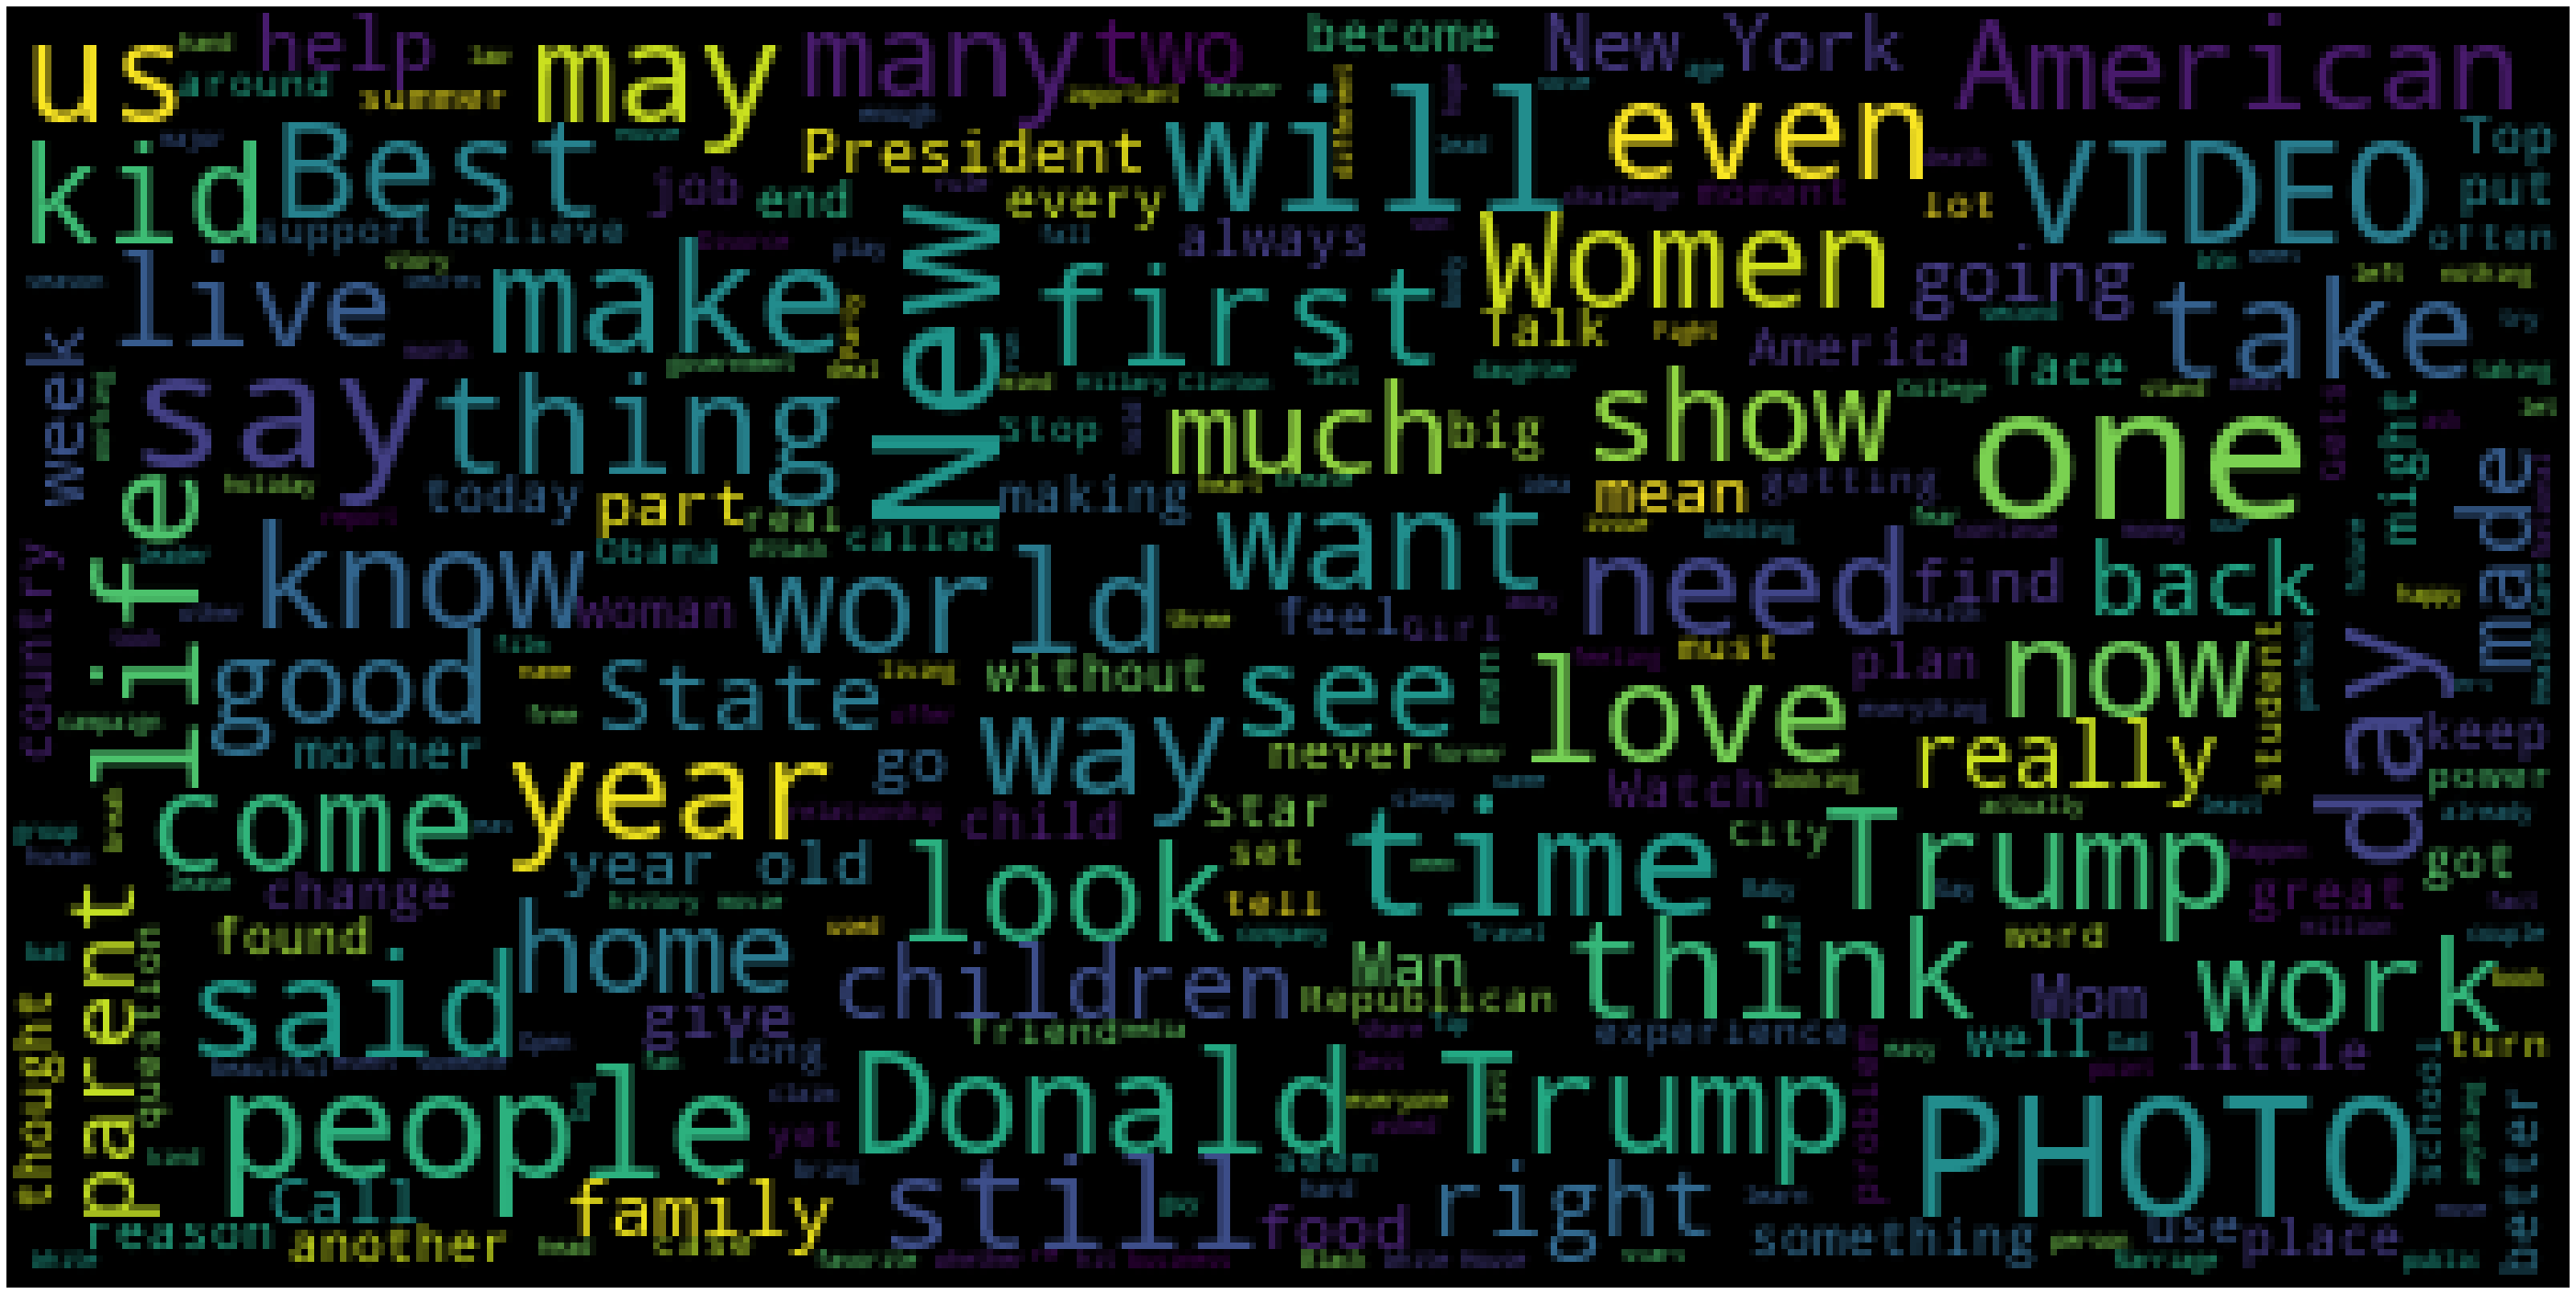

In [0]:
train_text = " ".join(train_title)
wordcloud = WordCloud().generate(train_text)
plt.figure()
plt.subplots(figsize=(50,50))
wordcloud = WordCloud(
    background_color="Black",
    max_words=len(train_text),
    max_font_size=30,
    relative_scaling=.5).generate(train_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Data Preprocessing
# Vectorizing the data using Bag of words (BOW)

In [0]:
tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
stop_words = nltk.corpus.stopwords.words("english")
c_vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_words)

In [0]:
c_vectorizer.fit(iter(train_title))
X_train = c_vectorizer.transform(iter(train_title))
X_devp = c_vectorizer.transform(iter(devp_title))
X_test = c_vectorizer.transform(iter(test_title))

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


**Categorical Encoding of category Column using Label Encoder**

In [0]:
encoder = LabelEncoder()
encoder.fit(train_category)
Y_train = encoder.transform(train_category)
Y_devp = encoder.transform(devp_category)
Y_test = encoder.transform(test_category)


**Feature Reduction**

In [0]:
print("Number of features before reduction : ", X_train.shape[1])
selection = VarianceThreshold(threshold=0.001)
X_train_whole = copy.deepcopy(X_train)
Y_train_whole = copy.deepcopy(Y_train)
selection.fit(X_train)
X_train = selection.transform(X_train)
X_devp = selection.transform(X_devp)
X_test = selection.transform(X_test)
print("Number of features after reduction : ", X_train.shape[1])


Number of features before reduction :  126124
Number of features after reduction :  3388


**Sampling the data**

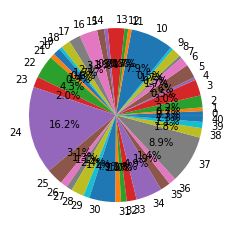

In [0]:
labels = list(set(Y_train))
counts = []
for label in labels:
    counts.append(np.count_nonzero(Y_train == label))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


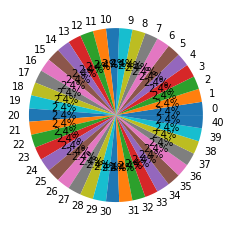

In [0]:
sm = SMOTE(random_state=42)
X_train, Y_train = sm.fit_sample(X_train, Y_train)
labels = list(set(Y_train))
counts = []
for label in labels:
    counts.append(np.count_nonzero(Y_train == label))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.show()
